In [1]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy.io as spio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

from modules import ELBO, optimize_ML

import os

### Setup parameters

In [2]:
# load sample trajectory
sim_idx = 0 # which out of the 100 trajectories to use
data_path = Path('data')
f_name = 'sim_0134.mat'
S = spio.loadmat(Path(data_path) / f_name)['S']
S_list = [S[0, i] for i in range(S.shape[1])]  # convert to list of structs

# unpack data
n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
n_dim = S_list[sim_idx]['x'][0, 0].shape[0]

### Run direct estimation algorithm (Maximum Likelihood) to initialize posterior probabilities

In [3]:
x, _, p, c, d, a = optimize_ML(n_dim, n_corr_obs, n_total_obs, verbose=True, n_starts=10)

Current loss: 294.65723602473736
Loss updated
Iteration 1 | Loss: 294.65723602473736
Current loss: 253.26094321534038
Loss updated
Iteration 2 | Loss: 253.26094321534038
Current loss: 270.5752365067601
Iteration 3 | Loss: 270.5752365067601
Current loss: 330.24251518398523
Iteration 4 | Loss: 330.24251518398523
Current loss: 334.24809524416924
Iteration 5 | Loss: 334.24809524416924
Current loss: 321.2867463603616
Iteration 6 | Loss: 321.2867463603616
Current loss: 368.5370402485132
Iteration 7 | Loss: 368.5370402485132
Current loss: 311.2955709658563
Iteration 8 | Loss: 311.2955709658563
Current loss: 321.909666441381
Iteration 9 | Loss: 321.909666441381
Current loss: 411.24034927785397
Iteration 10 | Loss: 411.24034927785397


In [4]:
# create initial values
mu_post_d_init = d.squeeze()
mu_post_c_init = c.squeeze()
mu_post_a_init = a.squeeze()
mu_post_l_init = torch.tensor([0.0])
mu_post_inits = torch.hstack((mu_post_d_init, mu_post_c_init, mu_post_a_init.flatten(), mu_post_l_init)).unsqueeze(1)
sigma_post_init = mu_post_inits @ mu_post_inits.T

mu_prior_d_init = torch.tensor([1.0])
mu_prior_c_init = torch.deg2rad(torch.tensor(60))
mu_prior_a_init = torch.zeros(n_dim, requires_grad=False) 
mu_prior_l_init = torch.tensor([0.0], requires_grad=False)

d_size = n_dim - 1
c_size = n_dim - 2
a_size = (n_dim - 1) * (n_dim - 2)
sigma_prior_d_init = torch.var(mu_post_d_init, correction=False, keepdim=True) + torch.mean(torch.diag(sigma_post_init)[:d_size])
sigma_prior_c_init = torch.var(mu_post_c_init, correction=False, keepdim=True) + torch.mean(torch.diag(sigma_post_init)[d_size:d_size + c_size])
sigma_prior_a_init = torch.var(mu_post_a_init, dim=1, correction=False) + torch.mean(torch.diag(sigma_post_init)[d_size + c_size:d_size + c_size + a_size])
sigma_prior_l_init = torch.tensor([1.0], requires_grad=False)

### Run inference

In [5]:
eps = 1e-6
model = ELBO(n_frames,
             n_dim, 
             mu_prior_d_init, 
             mu_prior_c_init, 
             mu_prior_a_init, 
             mu_prior_l_init, 
             sigma_prior_d_init,
             sigma_prior_c_init,
             sigma_prior_a_init,
             sigma_prior_l_init,
             mu_post_d_init,
             mu_post_c_init,
             mu_post_a_init,
             mu_post_l_init,
             sigma_post_init,
             eps=eps)

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# model_file = Path(out_dict) / f'model_{sim_curvature}.pt'

#### Optimize the whole ELBO

In [6]:
iterations = 40000

# errors
errors = np.zeros(iterations)
kl_loss = np.zeros(iterations)
ll_loss = np.zeros(iterations)

# variables
c_prior = np.zeros(iterations)
d_prior = np.zeros(iterations)
# c_post = np.zeros((N-1, iterations))
c_post = np.zeros((n_frames - 2, iterations))

best_iteration = 0
for i in range(iterations):
    
    # clear gradients
    optimizer.zero_grad()

    log_ll, d, c, a, p, x = model.compute_likelihood(n_corr_obs, n_total_obs, n_samples=100)
    kl = model.kl_divergence()
    loss = model.compute_loss(log_ll, kl)

    # gradient update
    loss.backward()
    optimizer.step()

    # store errors for each iteration
    errors[i] = loss.item()
    kl_loss[i] = kl.item()
    ll_loss[i] = log_ll.item()
    c_prior[i] = np.rad2deg(model.mu_prior_c.detach().numpy())
    d_prior[i] = model.mu_prior_d.detach().numpy()
    c_post[:, i] = np.rad2deg(model.mu_post_c.detach().numpy())

    # if i > 0:
        # if (np.abs(errors[i] - errors[i-1])) < 1e-3:
        #     errors = errors[:i]
        #     kl_loss = kl_loss[:i]
        #     ll_loss = ll_loss[:i]
        #     c_prior = c_prior[:i]
        #     d_prior = d_prior[:i]
        #     c_post = c_post[:, :i]
        #     break

    # print progress
    if not i % 250:
        print(f"Epoch: {i}, Loss: {loss.item()}")

# # save parameters
# phi_params = {'d': d_best,
#               'c': c_best,
#               'a': a_best}
# torch.save(phi_params, Path(data_path) / f'params_{sim_curvature}.pt')
# torch.save(model.state_dict(), model_file)

/var/folders/56/7xrzykp553j4850_g_vdc8mr0000gn/T/ipykernel_14445/3504519551.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_prior[i] = model.mu_prior_d.detach().numpy()


Epoch: 0, Loss: 2709.2765709175437
Epoch: 250, Loss: 2317.0746047071275
Epoch: 500, Loss: 2259.436032362458
Epoch: 750, Loss: 2200.455895661908
Epoch: 1000, Loss: 2247.5685190300137
Epoch: 1250, Loss: 2145.058928263961
Epoch: 1500, Loss: 2139.31421981693
Epoch: 1750, Loss: 2052.2588965648283
Epoch: 2000, Loss: 2078.095015668181
Epoch: 2250, Loss: 2025.0569139297147
Epoch: 2500, Loss: 2013.0718779751596
Epoch: 2750, Loss: 1990.87862066603
Epoch: 3000, Loss: 1989.9045965262424
Epoch: 3250, Loss: 1971.4921244865373
Epoch: 3500, Loss: 1905.6147519775066
Epoch: 3750, Loss: 1896.3068127500833
Epoch: 4000, Loss: 1836.0191784089345
Epoch: 4250, Loss: 1844.947207012987
Epoch: 4500, Loss: 1822.1168598774022
Epoch: 4750, Loss: 1806.8938068894063
Epoch: 5000, Loss: 1776.4254888680064
Epoch: 5250, Loss: 1770.3428213314683
Epoch: 5500, Loss: 1726.803118312889
Epoch: 5750, Loss: 1728.7261148820137
Epoch: 6000, Loss: 1682.2888956013985
Epoch: 6250, Loss: 1721.7530556407205
Epoch: 6500, Loss: 1672.0868

#### Load final model and plot error curves

/opt/anaconda3/envs/vision/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


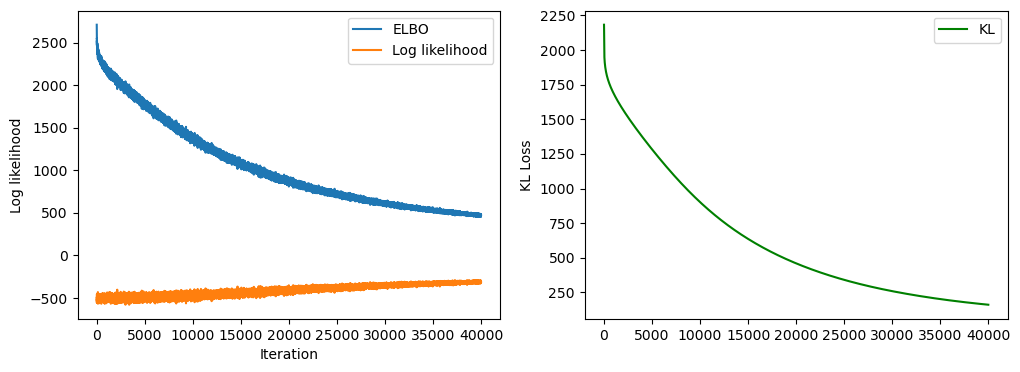

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Primary y-axis (ELBO and Neg. log likelihood)
axs[0].plot(errors, label='ELBO')
axs[0].plot(ll_loss, label='Log likelihood')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Log likelihood')
# axs[0].set_yscale('log')
# axs[0].tick_params(axis='y')

axs[1].plot(kl_loss, label='KL', color='green')
axs[1].set_ylabel('KL Loss')
# axs[1].tick_params(axis='y')
# axs[1].set_yscale('log')

# Add legends for both axes
axs[0].legend()
axs[1].legend()

# save and show the plot
# fig.suptitle('Loss over iterations')
# plt.savefig(Path(out_dict) / f"error_{sim_curvature}")
# plt.show()

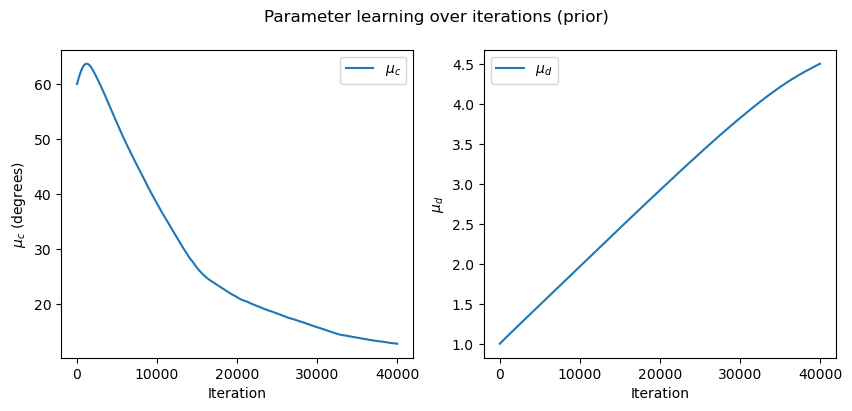

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

for i in range(2):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

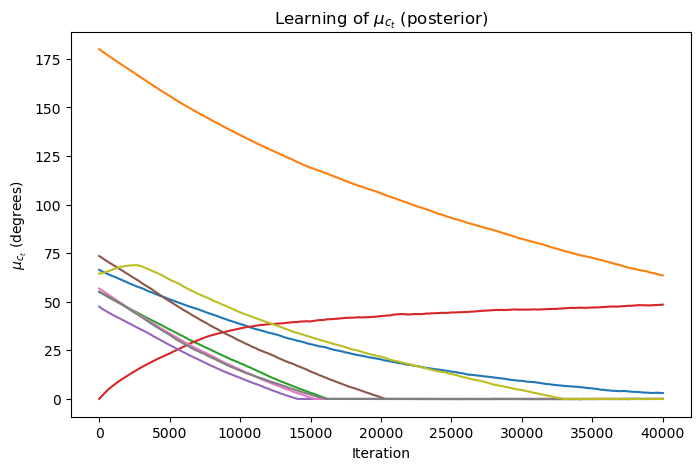

In [9]:
plt.figure(figsize=(8, 5))
for i in range(n_frames-2):
# for i in range(N-1):
    plt.plot(c_post[i, :])
plt.title(r"Learning of $\mu_{c_t}$ (posterior)")
plt.ylabel(r'$\mu_{c_t}$ (degrees)')
plt.xlabel("Iteration")
plt.show()

### Reconstruct trajectory

In [10]:
# est_global_curvature = best_model.mu_c.detach().numpy() * (180 / np.pi)
est_global_curvature = np.rad2deg(model.mu_prior_c.detach().numpy())
print(f'Estimated global curvature: {est_global_curvature} degrees')
# print(f'Average estimated local curvature: {torch.mean(c_best).detach().numpy() * (180/np.pi)} degrees')
print(f'Average estimated local curvature: {np.rad2deg(torch.mean(c).detach().numpy())} degrees')

Estimated global curvature: 12.768589973449707 degrees
Average estimated local curvature: 71.80433121380443 degrees


In [11]:
# compute PC-reduced perceptual locations
pca_true = PCA(n_components=2)
pca_fit = PCA(n_components=2)

# ground truth perceptual locations
pca_true.fit(S_list[sim_idx]['x'][0, 0])
pc_true = pca_true.components_

pca_fit.fit(x.squeeze().detach())
pc_fit = pca_fit.components_

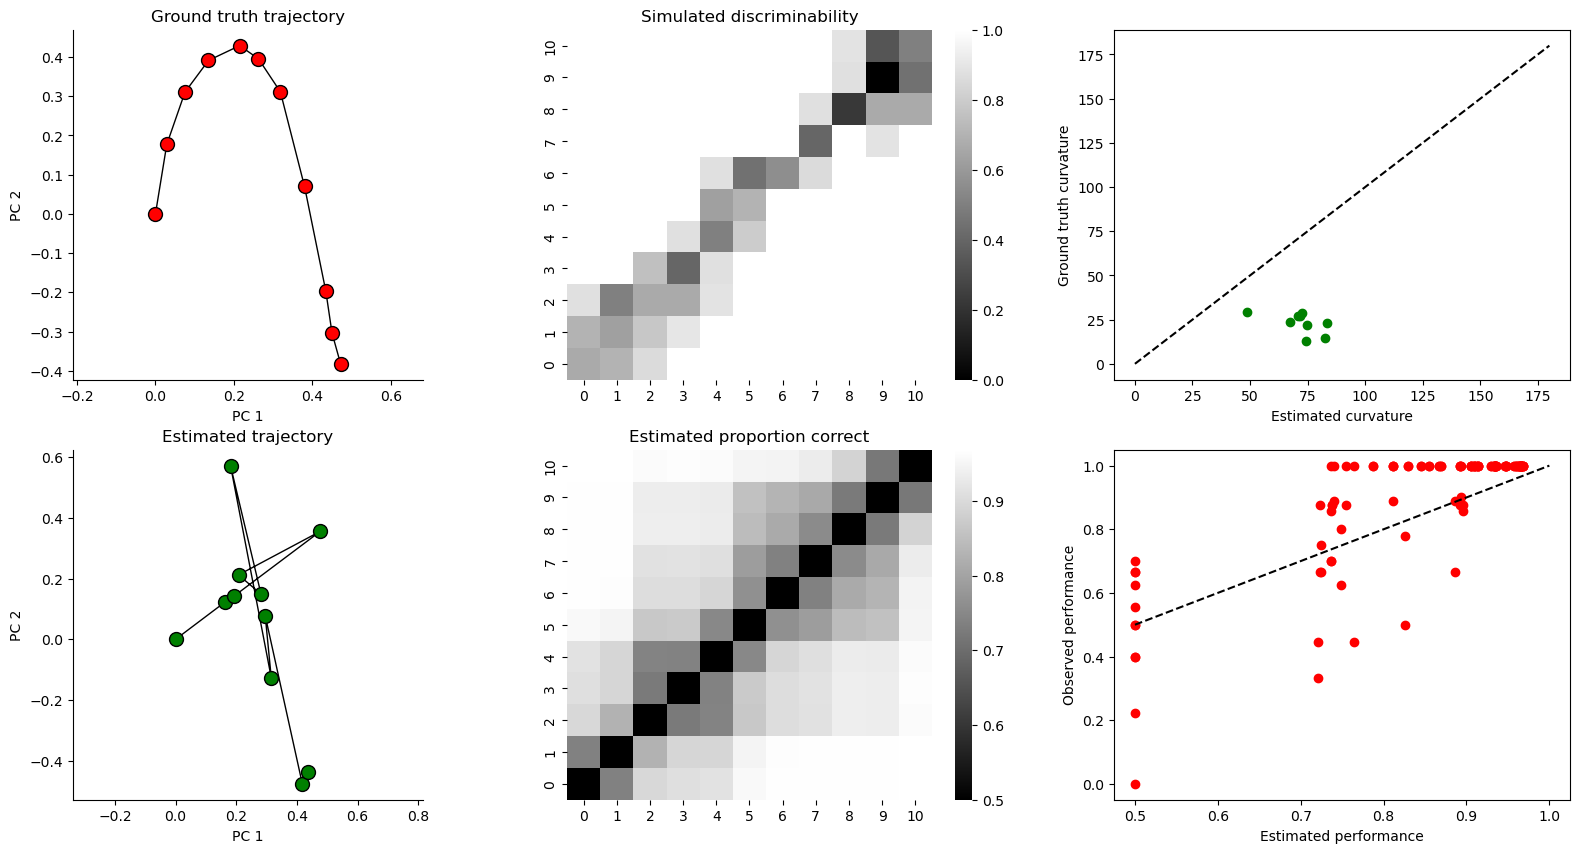

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].plot(pc_true[0, :], pc_true[1, :], '-ko', markersize=10, markerfacecolor='r', linewidth=1)
axs[0, 0].set_title('Ground truth trajectory')
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')
axs[0, 0].set_box_aspect(1)  
axs[0, 0].set_aspect('equal') 
axs[0, 0].spines['top'].set_visible(False)  
axs[0, 0].spines['right'].set_visible(False)

sns.heatmap(S_list[sim_idx]['Pc_reshaped'][0, 0], ax=axs[0, 1], cmap='gray')
axs[0, 1].invert_yaxis()
axs[0, 1].set_title('Simulated discriminability')

axs[0, 2].plot(torch.flatten(torch.rad2deg(c)).detach(), np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 'go')
axs[0, 2].plot([0, 180], [0, 180], 'k--')
axs[0, 2].set_xlabel('Estimated curvature')
axs[0, 2].set_ylabel('Ground truth curvature')

axs[1, 0].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[1, 0].set_title('Estimated trajectory')
axs[1, 0].set_xlabel('PC 1')
axs[1, 0].set_ylabel('PC 2')
axs[1, 0].set_box_aspect(1)  
axs[1, 0].set_aspect('equal') 
axs[1, 0].spines['top'].set_visible(False)  
axs[1, 0].spines['right'].set_visible(False)

sns.heatmap(p.detach().numpy().squeeze(), ax=axs[1, 1], cmap='gray')
axs[1, 1].invert_yaxis()
axs[1, 1].set_title('Estimated proportion correct')

axs[1, 2].plot(p.flatten().detach().numpy(), S_list[sim_idx]['Pc_reshaped'][0, 0].flatten(), 'ro')
axs[1, 2].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 2].set_xlabel('Estimated performance')
axs[1, 2].set_ylabel('Observed performance')

plt.show()